# Sample ML model testing
This notebook will create a model based on a few features we see are well correlated in multiple datasets. It will then run this model over all existing assembled datasets.

### Importing libraries
Because we want to display and interact with our data this will take a many libraries

In [1]:
#basic ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#basic system
import sys
import os
import glob

# math and signals
import math
from scipy.stats import entropy
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

# demo stuff
import ipywidgets as widgets
import seaborn 

In [2]:
# ml stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import tree
from sklearn import metrics
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import confusion_matrix
import joblib

## Importing and loading data
Here we take data from hardcoded paths. This can be changed later, but this is a proof of concept about our specific datasets at this point- not something for all scientists everywhere to use without modifying.

In [3]:
root_data_path ="C:/Projects/brainspin/not_pushed/data_anonymized/assembled"
TOP_data       = os.path.join(root_data_path,'top_stitched.csv') 
StrokeMRI_data = os.path.join(root_data_path,'StrokeMRI_stitched.csv')
Insight46_data = os.path.join(root_data_path,'Insight46_stitched.csv')

TOP_frame = pd.read_csv(TOP_data)
StrokeMRI_frame = pd.read_csv(StrokeMRI_data)
Insight46_frame = pd.read_csv(Insight46_data)

## Examining relationships in data

Here we will seperate a subset of variables earlier experiments and clinical
logic have shown to be of interest, then show heatmaps, and also examine plots.

In [4]:
#TOP_frame.columns

In [5]:
TOP_small_frame = TOP_frame[['Age','Sex','GM_ICVRatio', 'GMWM_ICVRatio','WMH_vol', 'WMH_count',]]
StrokeMRI_small_frame = StrokeMRI_frame[['Age','Sex','GM_ICVRatio', 'GMWM_ICVRatio','WMH_vol', 'WMH_count',]]
Insight46_small_frame = Insight46_frame[['Age','Sex','GM_ICVRatio', 'GMWM_ICVRatio','WMH_vol', 'WMH_count',]]

In [6]:
#StrokeMRI_small_frame.head(3)

In [7]:
#Insight46_small_frame.head(3)

In [8]:
#TOP_small_frame.head(3)

After examining the datasets we see there are small adjustments i.e. we must drop the NaN containing rows, and one moved header row from the top dataaset.

In [9]:
TOP_small_frame = TOP_small_frame[1:]
TOP_small_frame = TOP_small_frame.dropna()
StrokeMRI_small_frame = StrokeMRI_small_frame.dropna()
Insight46_small_frame = Insight46_small_frame.dropna()

<AxesSubplot:>

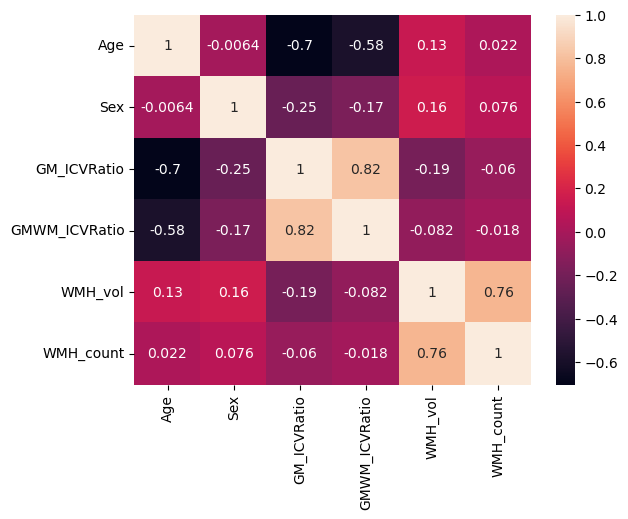

In [10]:
%matplotlib inline
seaborn.heatmap(TOP_small_frame.corr(), annot = True)

<AxesSubplot:>

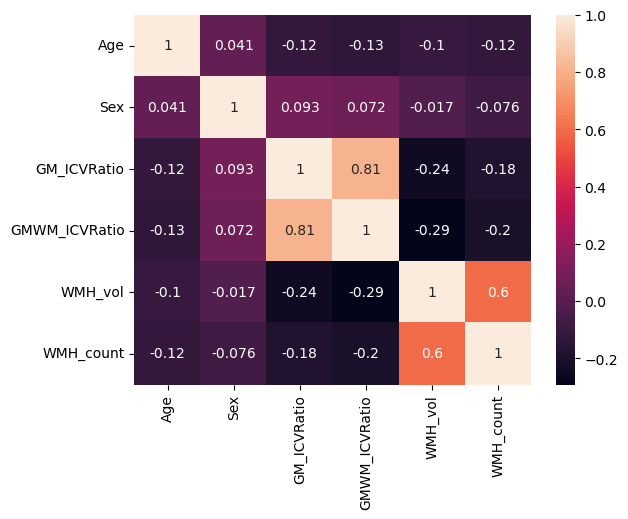

In [11]:
%matplotlib inline
seaborn.heatmap(Insight46_small_frame.corr(), annot = True)

<AxesSubplot:>

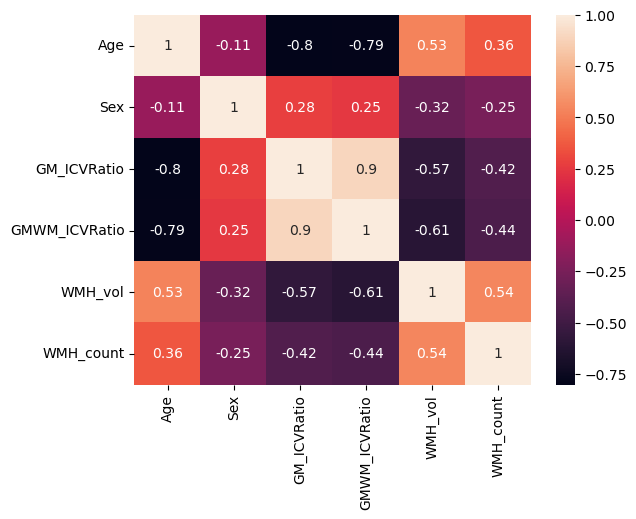

In [12]:
%matplotlib inline
seaborn.heatmap(StrokeMRI_small_frame.corr(), annot = True)

So we see that in the StrokeMRI dataset and the TOP datasets there is strong negative correlation beweeen age and brain size relative to crainial volume. There is a postiive correlation between age and volume and count of white matter hyperintensities. The insight 46 dataset does not have these expected correlations. Let's examine a bit further

In [13]:
Insight46_small_frame.describe()

,Age,Sex,GM_ICVRatio,GMWM_ICVRatio,WMH_vol,WMH_count
count,196.000000,196.000000,196.000000,196.000000,196.000000,196.000000
mean,70.699518,1.474490,0.405113,0.738381,5.725281,23.295918
std,0.656364,0.500628,0.021713,0.034565,7.221506,10.268407
min,69.263889,1.000000,0.356390,0.654770,0.256000,6.000000
25%,70.216667,1.000000,0.390010,0.711080,1.461000,16.000000
50%,70.740278,1.000000,0.406200,0.741290,3.182500,22.000000
75%,71.242361,2.000000,0.422967,0.768805,7.017750,28.000000
max,71.863889,2.000000,0.462930,0.797130,48.633000,74.000000


OK....the Insight46 dataset (or what is left when we get rid of NaN containing rows) basically has very little variance in age... so the results are not so strange after all.

## Model makeing and saving
We will make a model on the TOP dataset and save it.

In [14]:
ml_matrix = TOP_small_frame.copy()
X = ml_matrix.drop('Age', axis =1)
X = X.values
X = X.astype('float')

In [15]:
y = ml_matrix['Age'].values
y=y.astype('int')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_train.shape

(424, 5)

In [18]:
# scale
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [19]:
linr = LinearRegression()
linr.fit(X_train, y_train)

LinearRegression()

In [20]:
y_pred = linr.predict(X_test)

In [27]:

print('R2 score : %.3f' % metrics.r2_score(y_test,y_test))
print('Explained variance score: %.3f'  % metrics.explained_variance_score(y_test, y_pred))
print('Mean absolute error: %.3f'  % metrics.mean_absolute_error(y_test, y_pred))

R2 score Linear regression: 0.459
R2 score : 1.000
Explained variance score: 0.512
Mean absolute error: 5.298


## Important note: results may vary. That is why we save the models. The model saved on 17 June 2023
had an MAE of 5.298

R2 score: 1
Explained variance score: 0.512
Mean absolute error: 5.298

Saving name was:
    '../result_models/T1_obvious4_linearreg_notricks.sav'

Yeah! We have a model than can predict age within 5 years... no fancy k-folding or other optimization tricks...but that will come later.

In [24]:
# check if model folder exists and if not , then create
model_folder = '../result_models/'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

In [ ]:
file_given_name = input()

In [25]:
# save off file
#file_given_name = 'T1_obvious4_linearreg_notricks'
joblib.dump(linr, ('../result_models/' + file_given_name + '.sav'))
    

['../result_models/T1_obvious4_linearreg_notricks.sav']

## Now we can apply the model to our other datasets
and we will pull it from the saved file because we can (as an example)

let's pickle save as well for convenience

In [31]:
import pickle
pickle_filename = '../result_models/pickle_T1_obvious4_linearreg_notricks.sav'
pickle.dump(linr, open(pickle_filename, 'wb'))

In [32]:
model_filename = '../result_models/pickle_T1_obvious4_linearreg_notricks.sav'
loaded_model = pickle.load(open(model_filename, 'rb'))


In [48]:
MRIml_matrix = StrokeMRI_small_frame.copy()
MRIX = MRIml_matrix.drop('Age', axis =1)
MRIX = MRIX.values
MRIX = MRIX.astype('float')

len(MRIX)

533

In [55]:
MRIy = MRIml_matrix['Age']
#MRIy=y.astype('float')
len(MRIy)

533

In [56]:
MRIX_train, MRIX_test, MRIy_train, MRIy_test = train_test_split(MRIX, MRIy, test_size=0.2, random_state=42)

Here again we will scale, but actually, this is a very bad idea, probably, but this is just a demo

In [58]:
# scale
sc = StandardScaler()
sc.fit(MRIX_train)
MRIX_train = sc.transform(MRIX_train)
MRIX_test = sc.transform(MRIX_test)

In [59]:
MRIy_pred = loaded_model.predict(MRIX_test)

In [61]:
loaded_model

LinearRegression()

In [60]:

print('R2 score : %.3f' % metrics.r2_score(MRIy_test,MRIy_test))
print('Explained variance score: %.3f'  % metrics.explained_variance_score(MRIy_test, MRIy_pred))
print('Mean absolute error: %.3f'  % metrics.mean_absolute_error(MRIy_test, MRIy_pred))

R2 score : 1.000
Explained variance score: 0.565
Mean absolute error: 23.046


Ouch...this hurts...Our model had a huge mean absolute error on the StrokeMRI dataset. Let's try building a model it without scaling, and also applying without scaling. This step was indeed a bad choice. 

This makes sense the means of X were different. We bmust however ask if these numbers should be different- or whether they should be normalized. This tsv normalization is a possible next step.